# TS7: Filtrado digital lineal de ECG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
from pytc2.sistemas_lineales import plot_plantilla
from scipy import signal as sig
import scipy.io as sio

## Carga ECG

In [2]:
from utils_info import print_info_senal
fs = 1000  # Hz
mat_struct = sio.loadmat('ECG_TP4.mat')
ecg_lead = mat_struct['ecg_lead'].flatten()
ecg_lead = (ecg_lead - ecg_lead.mean())/ ecg_lead.std() 
N = ecg_lead.shape[0]
print_info_senal('ECG', ecg_lead, fs)

------ECG------
Cantidad de muestras:  1129116
Frecuencia de muestreo: 1000 Hz
Duracion de la señal: 1129.116 seg
Df: 0.001 Hz
Potencia:  1.0



## Armado de la Plantilla Band Pass Filter

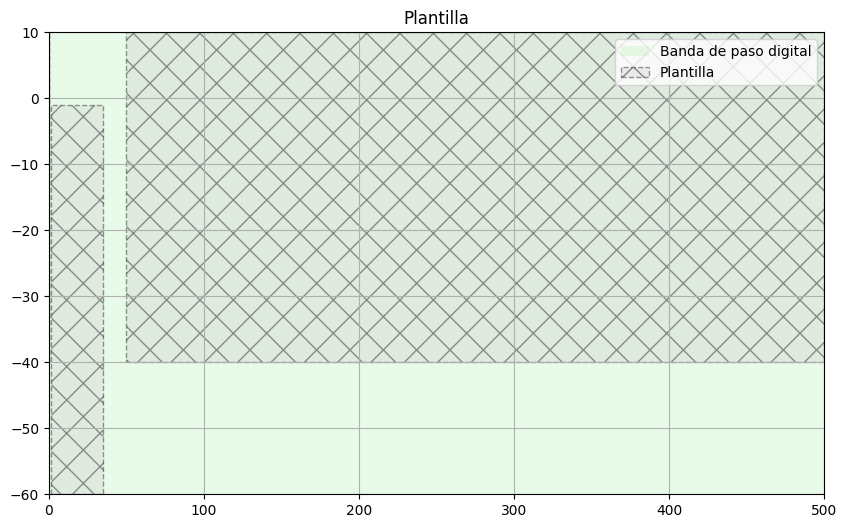

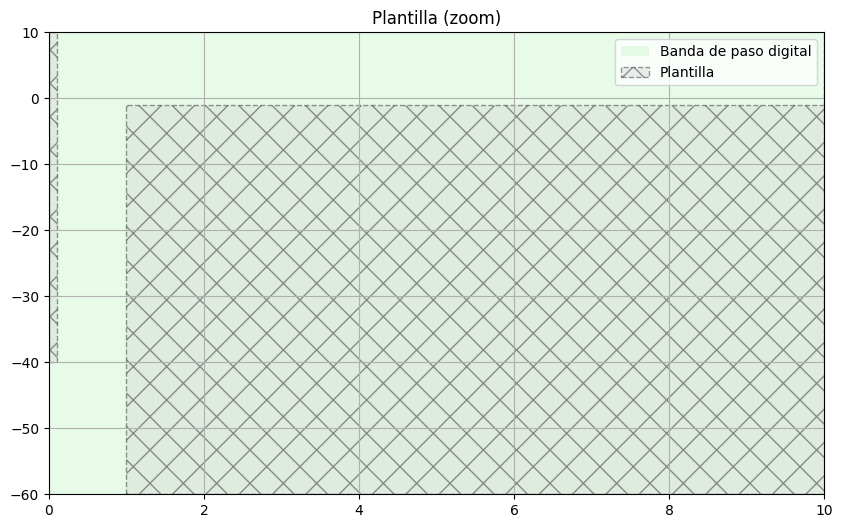

In [5]:
fpass = np.array([1.0, 35.0])       
fstop = np.array([0.1, 50.0])       
ripple = 1                         
attenuation = 40  

fig = plt.figure(figsize=(10, 6))
plt.title('Plantilla')
plt.grid(which='both', axis='both')
plt.xlim([0, 500])
plt.ylim([-60, 10]) 
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 6))
plt.title('Plantilla (zoom)')
plt.grid(which='both', axis='both')
plt.xlim([0, 10])
plt.ylim([-60, 10]) 
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.legend()
plt.show()


### Grilla con mejor resolucion

In [ ]:
w_Hz_raw = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.75, 250))
w_Hz_raw = np.append(w_Hz_raw, np.linspace(57, fs/2, 500))
w_rad = w_Hz_raw / (fs/2) * np.pi
w_Hz = w_rad / np.pi * (fs/2)

## FIR:

- Metodo de Ventanas: Kaiser
- Least Squares
- Remez

> La idea es armar por un lado el **Low Pass** y por otro el **High Pass** para luego convolucionarlos. Ya que como la plantilla es exigente y cero simetrica si de una armo pasa bandas no va a funcionar. 

#### HIGH PASS

In [7]:
ripple_2 = 0.1
frecs_hp = np.array([0.0, fstop[0], fpass[0], fs/2]) # 0 Hz, 0.1 Hz, 1 Hz, fs/2
frecs_hp_kaiser = np.array([0.0, 0.25, fpass[0], fs/2]) # 0 Hz, 0.1 Hz, 1 Hz, fs/2
gains_db_hp = np.array([-attenuation, -attenuation, -ripple_2, -ripple_2])
gains_db_hp_kaiser = np.array([-50, -40, -ripple_2, -ripple_2])
gains_hp = 10**(gains_db_hp / 20)
gains_hp_kaiser = 10**(gains_db_hp_kaiser / 20)


''' FIR: VENTANA - Kaiser '''
coef_k = 12005
num_k_hp = sig.firwin2(coef_k, frecs_hp_kaiser, gains_hp_kaiser, window=('kaiser',14), fs=fs)
_, h_k_hp = sig.freqz(num_k_hp, worN=w_rad)

''' FIR: Least Squares '''
coef_ls = 9005 
num_firls_hp = sig.firls(coef_ls, frecs_hp, gains_hp, fs=fs)
_, h_firls_hp = sig.freqz(num_firls_hp, worN=w_rad)

''' FIR: Remez '''
coef_r_hp = 2501
bands_hp = [0.0, fstop[0], fpass[0], fs/2]  # Stop: 0–0.1 Hz, Pass: 1–500 Hz
desired_hp = [0, 1]                         # Ganancia por banda
num_remez_hp = sig.remez(coef_r_hp, bands_hp, desired_hp, fs=fs)
_, h_remez_hp = sig.freqz(num_remez_hp, worN=w_rad)

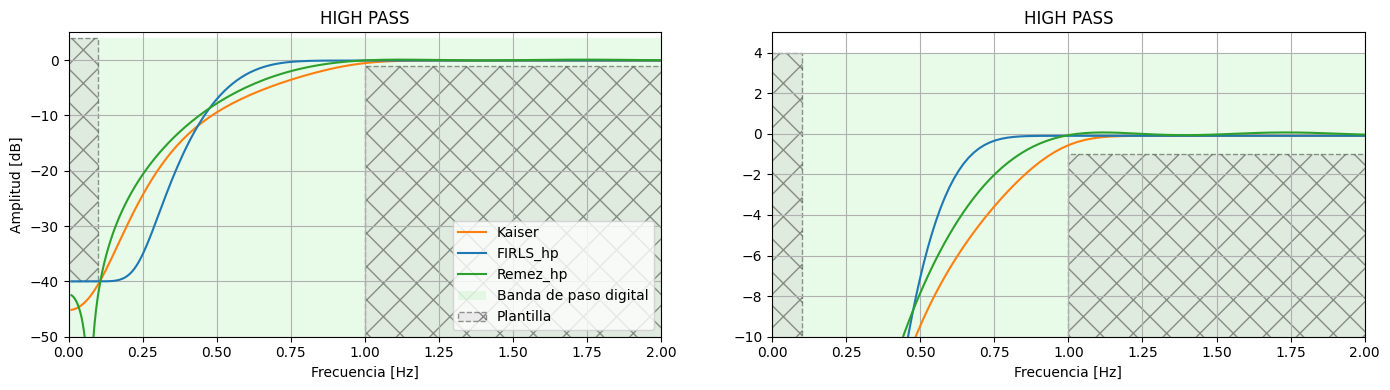

In [8]:
fig = plt.figure(figsize=(14, 4))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 0.005, 1])  # 2:gap:1 = 66%-gap-34%

ax1 = fig.add_subplot(gs[0, 0])
plt.sca(ax1)
plt.plot(w_Hz, 20 * np.log10(np.abs(h_k_hp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_firls_hp) + 1e-10), label='FIRLS_hp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_remez_hp) + 1e-10), label='Remez_hp', color='tab:green')
plot_plantilla(filter_type='highpass',fpass=1.0,ripple=1.0,fstop=0.1,attenuation=40.0,fs=fs)
plt.title('HIGH PASS')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.ylim(-50, 5)
plt.xlim(0, 2)
plt.grid(True)
plt.legend(loc='lower right')

ax2 = fig.add_subplot(gs[0, 2])
plt.sca(ax2)
plt.plot(w_Hz, 20 * np.log10(np.abs(h_k_hp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_firls_hp) + 1e-10), color='tab:blue', label='FIRLS_hp')	
plt.plot(w_Hz, 20 * np.log10(np.abs(h_remez_hp) + 1e-10), color='tab:green', label='Remez_hp')
plot_plantilla(filter_type='highpass',fpass=1.0,ripple=1.0,fstop=0.1,attenuation=40.0,fs=fs)
plt.title('HIGH PASS')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, 2)
plt.ylim(-10, 5)
plt.grid(True)
plt.tight_layout()
plt.show()

#### LOW PASS

In [9]:
ripple_2 = 0.5
ripple_1 = 1.0
frecs_lp = np.array([0.0, fpass[1], fstop[1], fs/2]) 
frecs_lp_kaiser = np.array([0.0, fpass[1], 49, fs/2]) 
gains_db_lp = np.array([-ripple_2, -ripple_2, -attenuation, -attenuation])
gains_lp = 10**(gains_db_lp / 20)


''' FIR: VENTANA - Kaiser '''
coef= 7005
num_k_lp = sig.firwin2(coef, frecs_lp_kaiser, gains_lp, window=('kaiser',14), fs=fs)
_, h_k_lp = sig.freqz(num_k_lp, worN=w_rad)

''' FIR: Least Squares '''
coef_2 = 305
num_firls_lp = sig.firls(coef_2, frecs_lp, gains_lp, fs=fs)
_, h_firls_lp = sig.freqz(num_firls_lp, worN=w_rad)

''' FIR: Remez '''
coef_r_lp = 201
bands_lp = [0.0, fpass[1], fstop[1], fs/2]  
desired_lp = [1, 0]                         
num_remez_lp = sig.remez(coef_r_lp, bands_lp, desired_lp, fs=fs)
_, h_remez_lp = sig.freqz(num_remez_lp, worN=w_rad)



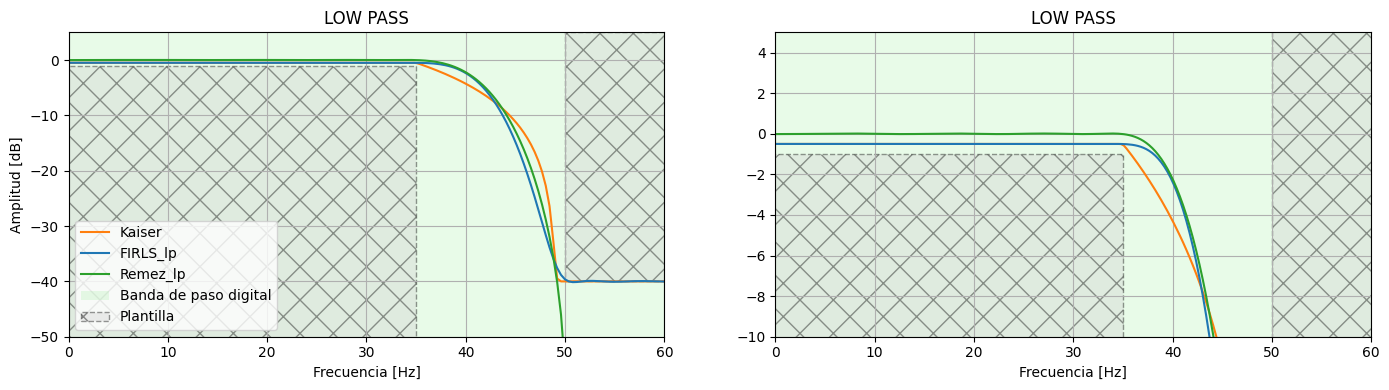

In [10]:
fig = plt.figure(figsize=(14, 4))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 0.005, 1])  # 2:gap:1 = 66%-gap-34%

ax1 = fig.add_subplot(gs[0, 0])
plt.sca(ax1)
plt.plot(w_Hz, 20 * np.log10(np.abs(h_k_lp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_firls_lp) + 1e-10), label='FIRLS_lp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_remez_lp) + 1e-10), label='Remez_lp', color='tab:green')
plot_plantilla(filter_type='lowpass',fpass=35.0,ripple=1.0,fstop=50.0,attenuation=40.0,fs=fs)
plt.title('LOW PASS')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.ylim(-50, 5)
plt.xlim(0, 60)
plt.grid(True)
plt.legend(loc='lower left')

ax2 = fig.add_subplot(gs[0, 2])
plt.sca(ax2)
plt.plot(w_Hz, 20 * np.log10(np.abs(h_k_lp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_firls_lp) + 1e-10), color='tab:blue', label='FIRLS_lp')	
plt.plot(w_Hz, 20 * np.log10(np.abs(h_remez_lp) + 1e-10), color='tab:green', label='Remez_lp')
plot_plantilla(filter_type='lowpass',fpass=35.0,ripple=1.0,fstop=50.0,attenuation=40.0,fs=fs)
plt.title('LOW PASS')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, 60)
plt.ylim(-10, 5)
plt.grid(True)
plt.tight_layout()
plt.show()


#### BAND PASS

In [11]:
h_k_bp = np.convolve(num_k_lp, num_k_hp)
h_firls_bp = np.convolve(num_firls_lp, num_firls_hp)
h_remez_bp = np.convolve(num_remez_lp, num_remez_hp)
_, H_k_bp = sig.freqz(h_k_bp, worN=w_rad)
_, H_firls_bp = sig.freqz(h_firls_bp, worN=w_rad)
_, H_remez_bp = sig.freqz(h_remez_bp, worN=w_rad)

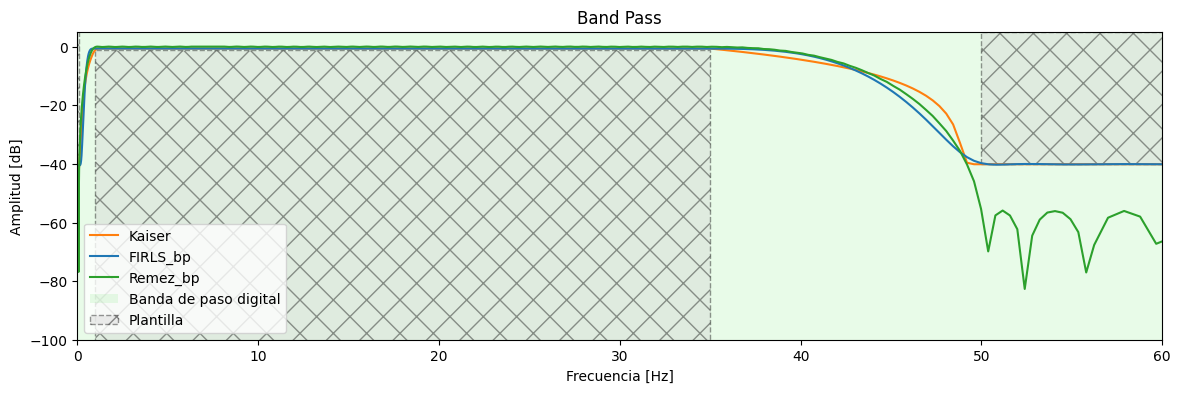

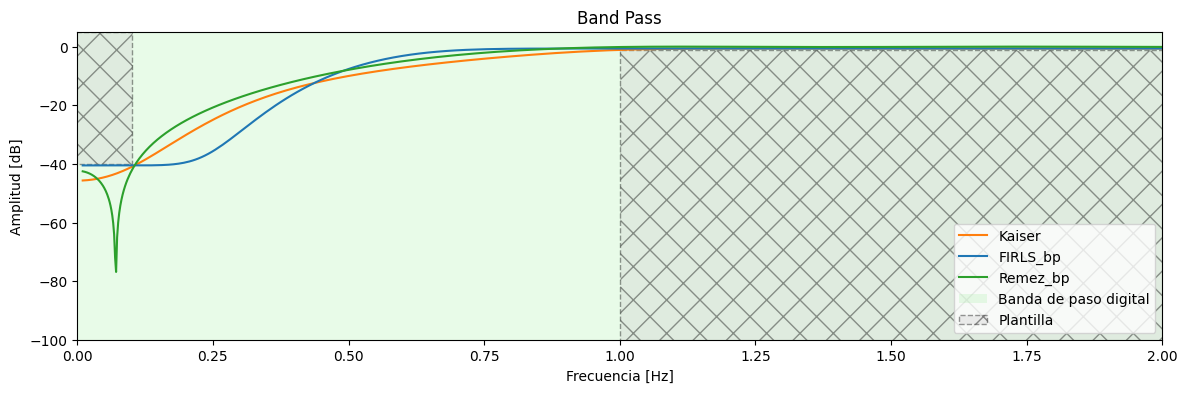

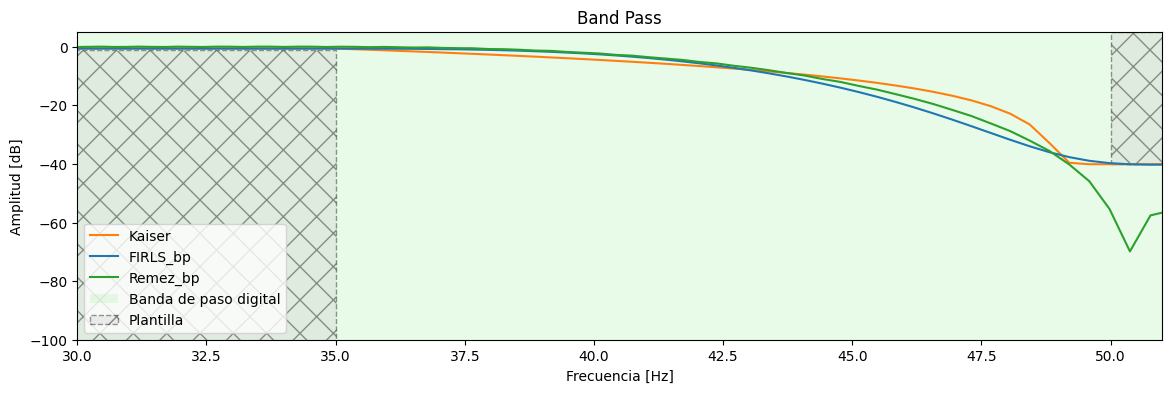

In [16]:
fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(H_k_bp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_firls_bp) + 1e-10), label='FIRLS_bp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_remez_bp) + 1e-10), label='Remez_bp', color='tab:green')
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.xlim(0, 60)
plt.title('Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.legend()

fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(H_k_bp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_firls_bp) + 1e-10), label='FIRLS_bp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_remez_bp) + 1e-10), label='Remez_bp', color='tab:green')
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.xlim(0, 2)
plt.title('Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.legend()

fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(H_k_bp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_firls_bp) + 1e-10), label='FIRLS_bp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_remez_bp) + 1e-10), label='Remez_bp', color='tab:green')
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.xlim(30, 51)
plt.title('Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.legend()

## IIR
- Butterworth
- Cheby1

In [17]:
fs = 1000
fpass = np.array([1.0, 35.0])       
fstop = np.array([0.1, 50.0])       
ripple = 0.1                         
attenuation = 40                    
''' IIR: Butterworth '''
mi_sos_butter = sig.iirdesign(
    fpass,
    fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype='butter',
    output='sos',
    fs=fs
)
w_butter, hh_butter = sig.sosfreqz(mi_sos_butter, worN=w_rad)
''' IIR: Chebyshev 1 '''
mi_sos_cheby = sig.iirdesign(
    fpass,
    fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype='cheby1',
    output='sos',
    fs=fs
)
w_cheby, hh_cheby = sig.sosfreqz(mi_sos_cheby, worN=w_rad)

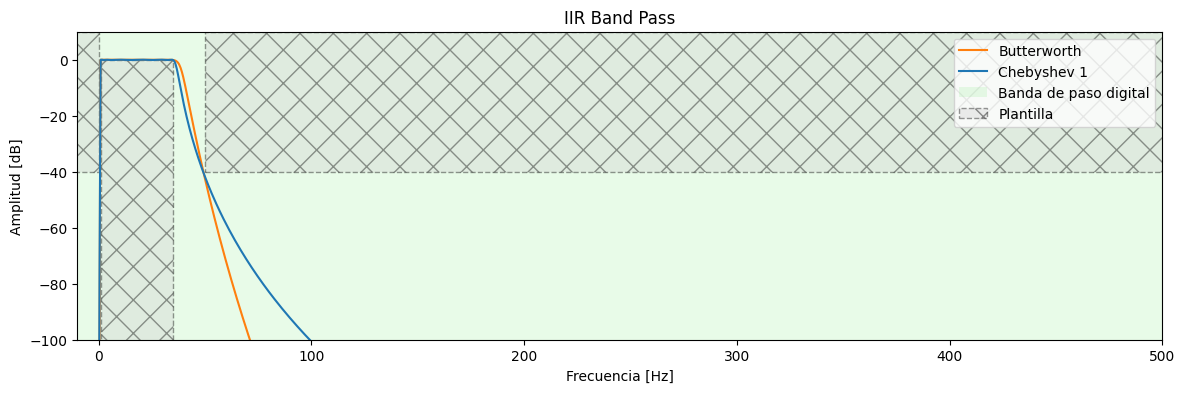

In [19]:
fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(hh_butter) + 1e-10), color='tab:orange', label='Butterworth')
plt.plot(w_Hz, 20 * np.log10(np.abs(hh_cheby) + 1e-10), color='tab:blue', label='Chebyshev 1')
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple, fstop=fstop, attenuation=attenuation, fs=fs)
plt.title('IIR Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.xlim(-10, 500)
plt.legend()
plt.show()

#### Aplico Filtros:

In [20]:
''' Aplicación de filtros IIR '''
ecg_lead_iir_butter = sig.sosfiltfilt(mi_sos_butter, ecg_lead)
ecg_lead_iir_cheby = sig.sosfiltfilt(mi_sos_cheby, ecg_lead)

''' Aplicación de filtros FIR '''
ecg_lead_fir_k = sig.filtfilt(h_k_bp, 1.0, ecg_lead)
ecg_lead_fir_firls = sig.filtfilt(h_firls_bp, 1.0, ecg_lead)
ecg_lead_fir_remez = sig.filtfilt(h_remez_bp, 1.0, ecg_lead)

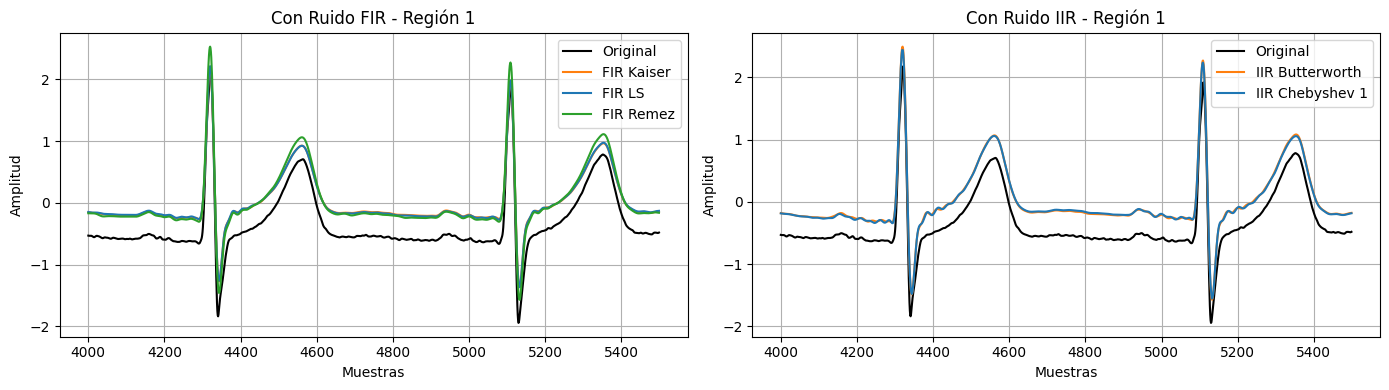

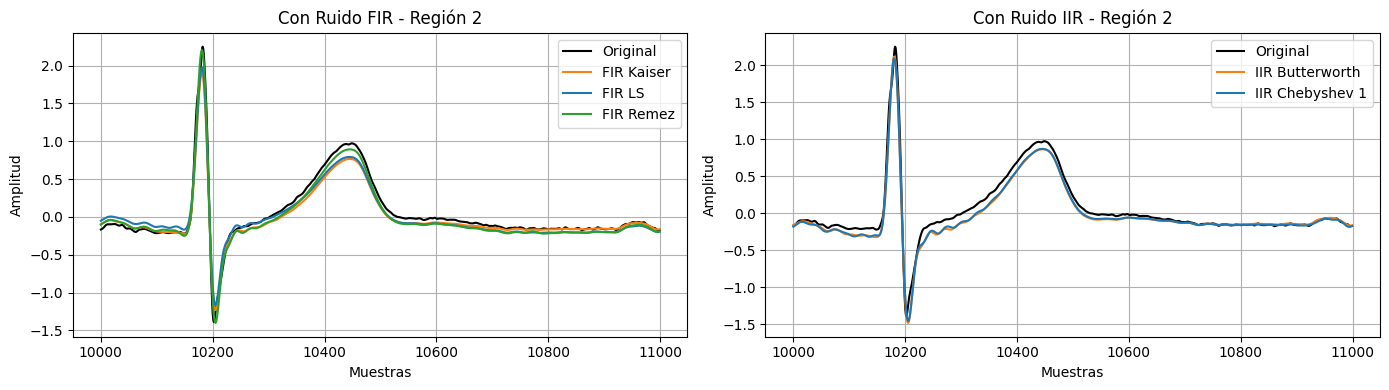

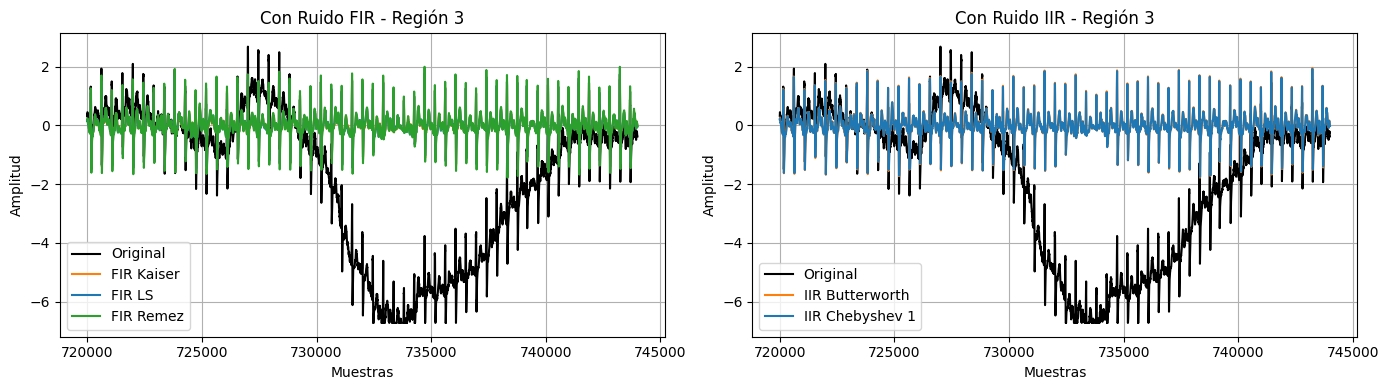

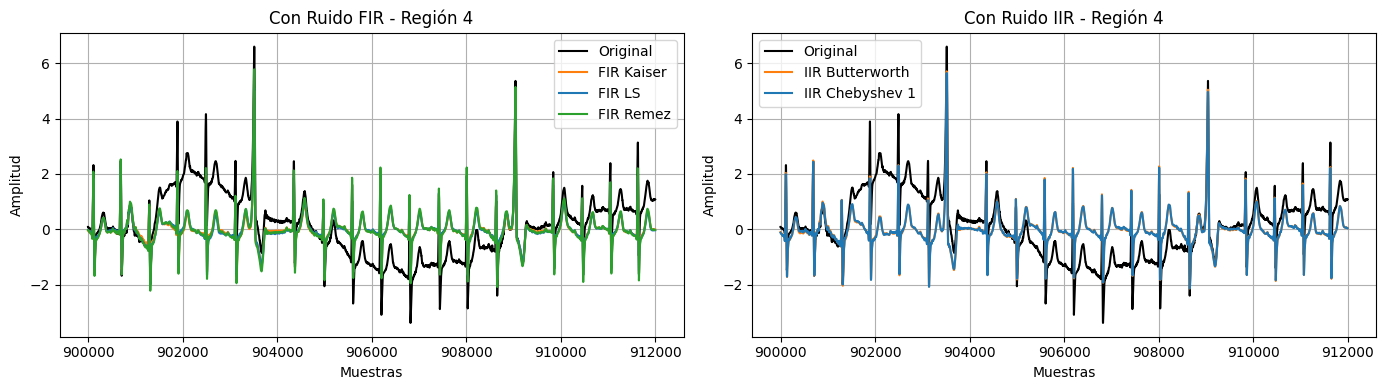

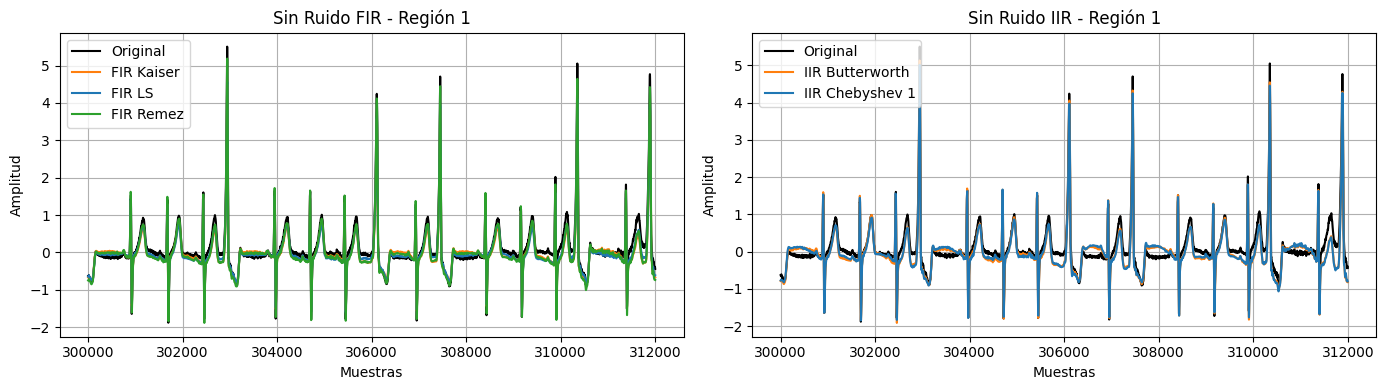

In [23]:
regs_con_ruido = [
    [4000, 5500],
    [10000, 11000],
    (np.array([12, 12.4]) * 60 * fs).astype(int),
    (np.array([15, 15.2]) * 60 * fs).astype(int)
]

regs_sin_ruido = [
    (np.array([5, 5.2]) * 60 * fs).astype(int),
]

# Función para plotear
def plot_comparacion_filtros(ecg_original, ecg_fir_k, ecg_fir_firls, ecg_fir_remez,
                              ecg_iir_butter, ecg_iir_cheby, regiones, titulo_base):
    for i, (start, end) in enumerate(regiones):
        eje_x = np.arange(start, end)
        fig, axs = plt.subplots(1, 2, figsize=(14, 4))
        
        # FIR
        axs[0].plot(eje_x, ecg_original[start:end], label='Original', color='k')
        axs[0].plot(eje_x, ecg_fir_k[start:end], label='FIR Kaiser', color='tab:orange')
        axs[0].plot(eje_x, ecg_fir_firls[start:end], label='FIR LS', color='tab:blue')
        axs[0].plot(eje_x, ecg_fir_remez[start:end], label='FIR Remez', color='tab:green')
        axs[0].set_title(f'{titulo_base} FIR - Región {i+1}')
        axs[0].set_xlabel('Muestras')
        axs[0].set_ylabel('Amplitud')
        axs[0].legend()
        axs[0].grid(True)

        # IIR
        axs[1].plot(eje_x, ecg_original[start:end], label='Original', color='k')
        axs[1].plot(eje_x, ecg_iir_butter[start:end], label='IIR Butterworth', color='tab:orange')
        axs[1].plot(eje_x, ecg_iir_cheby[start:end], label='IIR Chebyshev 1', color='tab:blue')
        axs[1].set_title(f'{titulo_base} IIR - Región {i+1}')
        axs[1].set_xlabel('Muestras')
        axs[1].set_ylabel('Amplitud')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()



plot_comparacion_filtros(ecg_lead, ecg_lead_fir_k, ecg_lead_fir_firls, ecg_lead_fir_remez,
                         ecg_lead_iir_butter, ecg_lead_iir_cheby, regs_con_ruido, 'Con Ruido')

plot_comparacion_filtros(ecg_lead, ecg_lead_fir_k, ecg_lead_fir_firls, ecg_lead_fir_remez,
                         ecg_lead_iir_butter, ecg_lead_iir_cheby, regs_sin_ruido, 'Sin Ruido')


# BONUS :)

Para el bonus repito todo lo que hice para ECG pero ahora para PPG

- **Banda de paso**: 0.5 Hz a 5 Hz  
  Esta banda permite conservar las componentes fisiológicas relevantes de la señal PPG, que están asociadas a la actividad cardíaca y respiratoria.

- **Banda de stop**:
  - Inferior: 0 Hz a 0.2 Hz  
    Se elimina muy baja frecuencia (movimiento, artefactos lentos).
  - Superior: 8 Hz a fs/2  
    Se atenúan componentes de alta frecuencia no deseadas .

Se establecieron los siguientes parámetros de diseño:
- **Ripple en banda de paso**: 1 dB
- **Atenuación en banda de stop**: 40 dB

In [24]:
from utils_info import print_info_senal
ppg_con_ruido = np.loadtxt('PPG.csv', delimiter=',')
ppg = ppg_con_ruido.flatten()
ppg = (ppg - ppg.mean()) / ppg.std()  # Normalizar la señal
N = ppg.shape[0]
fs = 400  
print_info_senal('PPG', ppg, fs)

------PPG------
Cantidad de muestras:  45320
Frecuencia de muestreo: 400 Hz
Duracion de la señal: 113.3 seg
Df: 0.009 Hz
Potencia:  1.0



## Plantilla

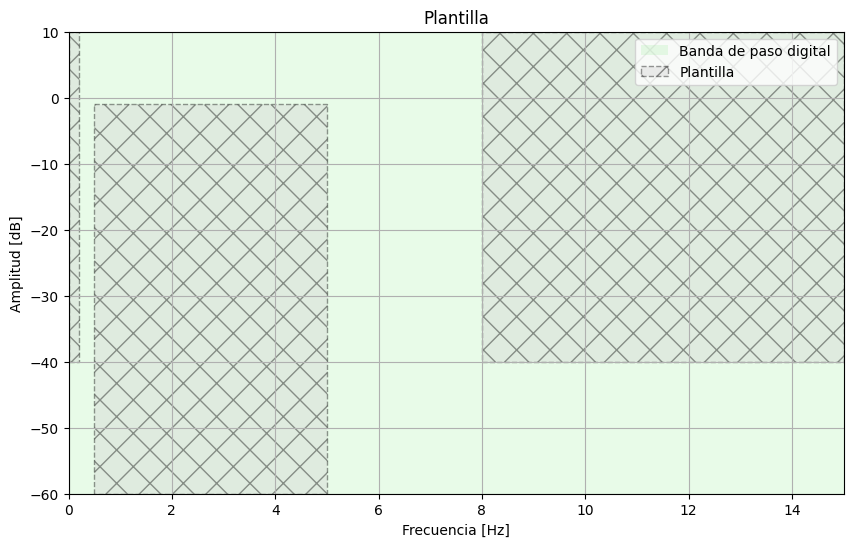

In [26]:
fpass = np.array([0.5, 5.0])      
fstop = np.array([0.2, 8.0])       
ripple = 1.0               
attenuation = 40            


fig = plt.figure(figsize=(10, 6))
plt.title('Plantilla')
plt.grid(which='both', axis='both')
plt.xlim([0, 15])
plt.ylim([-60, 10]) 
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')

plt.legend()
plt.show()

#### Grilla con mejor resolucion

In [28]:
w_Hz_raw = np.append(np.logspace(-2, 0.5, 250), np.logspace(0.6, 0.9, 250))
w_Hz_raw = np.append(w_Hz_raw, np.linspace(9, fs/2, 500))

w_rad = w_Hz_raw / (fs/2) * np.pi
w_Hz = w_rad / np.pi * (fs/2)

# FIR

Primero armo los High Pass y Low Pass y los convoluciono

In [29]:
#%%############################ 
#####  High pass filter   #####
###############################

ripple_2 = 0.1

# Plantilla ajustada para PPG
frecs_hp = np.array([0.0, fstop[0], fpass[0], fs/2])               # [0, 0.2, 0.5, 200]
frecs_hp_kaiser = np.array([0.0, 0.35, fpass[0], fs/2])             # más suave transición

# Ganancia en dB (plantilla)
gains_db_hp = np.array([-attenuation, -attenuation, -ripple_2, -ripple_2])
gains_db_hp_kaiser = np.array([-attenuation-20, -attenuation-30, -0.05, -ripple_2])
gains_db_hp_remez = np.array([-attenuation-20, -attenuation, -ripple_2, -ripple_2])

# Conversión a ganancia lineal
gains_hp = 10**(gains_db_hp / 20)
gains_hp_kaiser = 10**(gains_db_hp_kaiser / 20)
gains_hp_remez = 10**(gains_db_hp_remez / 20)

''' FIR: VENTANA - Kaiser '''
coef_k = 6005  # largo para buena selectividad
num_k_hp = sig.firwin2(coef_k, frecs_hp_kaiser, gains_hp_kaiser, window=('kaiser', 14), fs=fs)
_, h_k_hp = sig.freqz(num_k_hp, worN=w_rad)

''' FIR: Least Squares '''
coef_ls = 3005
num_firls_hp = sig.firls(coef_ls, frecs_hp, gains_hp, fs=fs)
_, h_firls_hp = sig.freqz(num_firls_hp, worN=w_rad)

''' FIR: Remez '''
coef_r_hp = 1501
bands_hp = [0.0, 0.2, fpass[0], fs/2]  # Stop: 0–0.2 Hz, Pass: 0.5–200 Hz
frecs_hp_re = np.array([0.0, 0.2, fpass[0], fs/2])   #le doy changui
desired_hp = [0, 1]
num_remez_hp = sig.remez(coef_r_hp, frecs_hp_re, gains_hp_remez[::2], fs=fs)
_, h_remez_hp = sig.freqz(num_remez_hp, worN=w_rad)

#%%############################ 
#####  Low  pass filter   #####
###############################
ripple_2 = 0.5
frecs_lp = np.array([0.0, fpass[1], fstop[1], fs/2])  # [0.0, 5.0, 8.0, 200.0]
frecs_lp_kaiser = np.array([0.0, fpass[1], 7, fs/2])  # para tener margen justo antes del stop
gains_db_lp = np.array([-ripple_2, -ripple_2, -attenuation, -attenuation])
gains_lp = 10**(gains_db_lp / 20)

# FIR: VENTANA - Kaiser
coef = 7005
num_k_lp = sig.firwin2(coef, frecs_lp_kaiser, gains_lp, window=('kaiser',14), fs=fs)
_, h_k_lp = sig.freqz(num_k_lp, worN=w_rad)

# FIR: Least Squares
coef_2 = 905
num_firls_lp = sig.firls(coef_2, frecs_lp, gains_lp, fs=fs)
_, h_firls_lp = sig.freqz(num_firls_lp, worN=w_rad)

# FIR: Remez
coef_r_lp = 601
bands_lp = [0.0, fpass[1], fstop[1], fs/2]  # [0.0, 5.0, 8.0, 200.0]
desired_lp = [1, 0]
num_remez_lp = sig.remez(coef_r_lp, bands_lp, desired_lp, fs=fs)
_, h_remez_lp = sig.freqz(num_remez_lp, worN=w_rad)

#%%############################ 
#####  Band pass filter   #####
###############################

h_k_bp = np.convolve(num_k_lp, num_k_hp, mode = 'same')
h_firls_bp = np.convolve(num_firls_lp, num_firls_hp, mode = 'same')
h_remez_bp = np.convolve(num_remez_lp, num_remez_hp, mode = 'same')
_, H_k_bp = sig.freqz(h_k_bp, worN=w_rad)
_, H_firls_bp = sig.freqz(h_firls_bp, worN=w_rad)
_, H_remez_bp = sig.freqz(h_remez_bp, worN=w_rad)


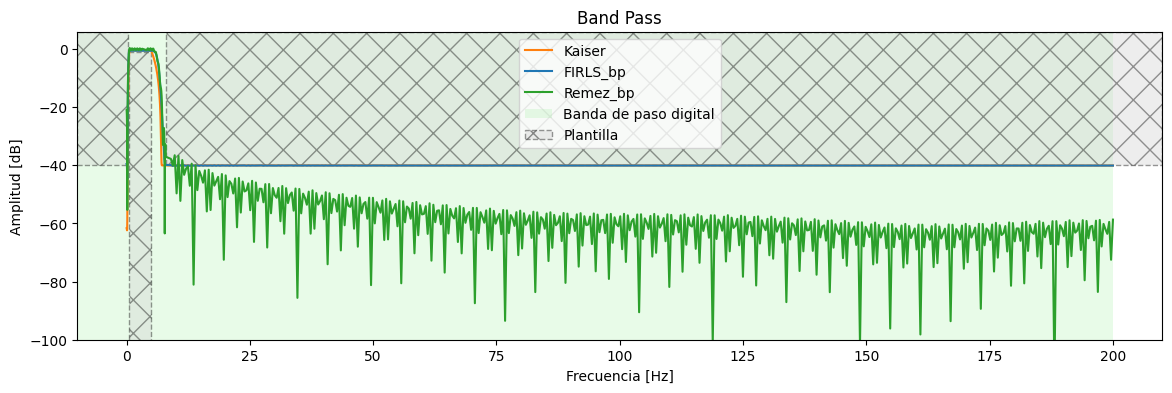

In [30]:
fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(H_k_bp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_firls_bp) + 1e-10), label='FIRLS_bp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_remez_bp) + 1e-10), label='Remez_bp', color='tab:green')
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.title('Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.legend()

# IIR

In [31]:
fs = 400
fpass = np.array([0.5, 5.0])         # Banda de paso para PPG
fstop = np.array([0.2, 8.0])         # Banda de stop para PPG
ripple = 0.1                         # dB
attenuation = 40                    # dB

''' IIR: Butterworth '''
mi_sos_butter = sig.iirdesign(
    fpass,
    fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype='butter',
    output='sos',
    fs=fs
)
w_butter, hh_butter = sig.sosfreqz(mi_sos_butter, worN=w_rad)

''' IIR: Chebyshev 1 '''
mi_sos_cheby = sig.iirdesign(
    fpass,
    fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype='cheby1',
    output='sos',
    fs=fs
)
w_cheby, hh_cheby = sig.sosfreqz(mi_sos_cheby, worN=w_rad)


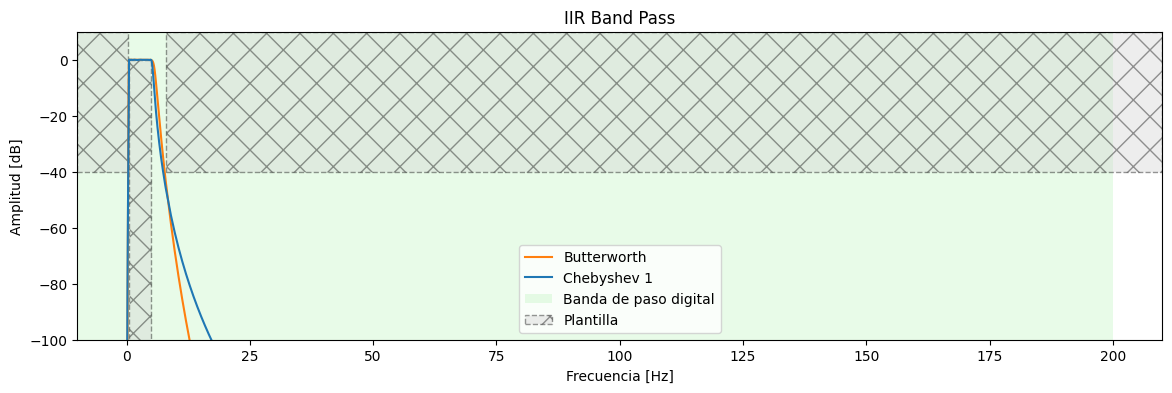

In [33]:
fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(hh_butter) + 1e-10), color='tab:orange', label='Butterworth')
plt.plot(w_Hz, 20 * np.log10(np.abs(hh_cheby) + 1e-10), color='tab:blue', label='Chebyshev 1')
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple, fstop=fstop, attenuation=attenuation, fs=fs)
plt.title('IIR Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.legend()
plt.show()

### Aplicacion de fitros

In [34]:
''' Aplicación de filtros IIR '''
ppg_iir_butter = sig.sosfiltfilt(mi_sos_butter, ppg)
ppg_iir_cheby = sig.sosfiltfilt(mi_sos_cheby, ppg)

''' Aplicación de filtros FIR '''
ppg_fir_kaiser = sig.filtfilt(h_k_bp, 1.0, ppg)
ppg_fir_firls = sig.filtfilt(h_firls_bp, 1.0, ppg)
ppg_fir_remez = sig.filtfilt(h_remez_bp, 1.0, ppg)

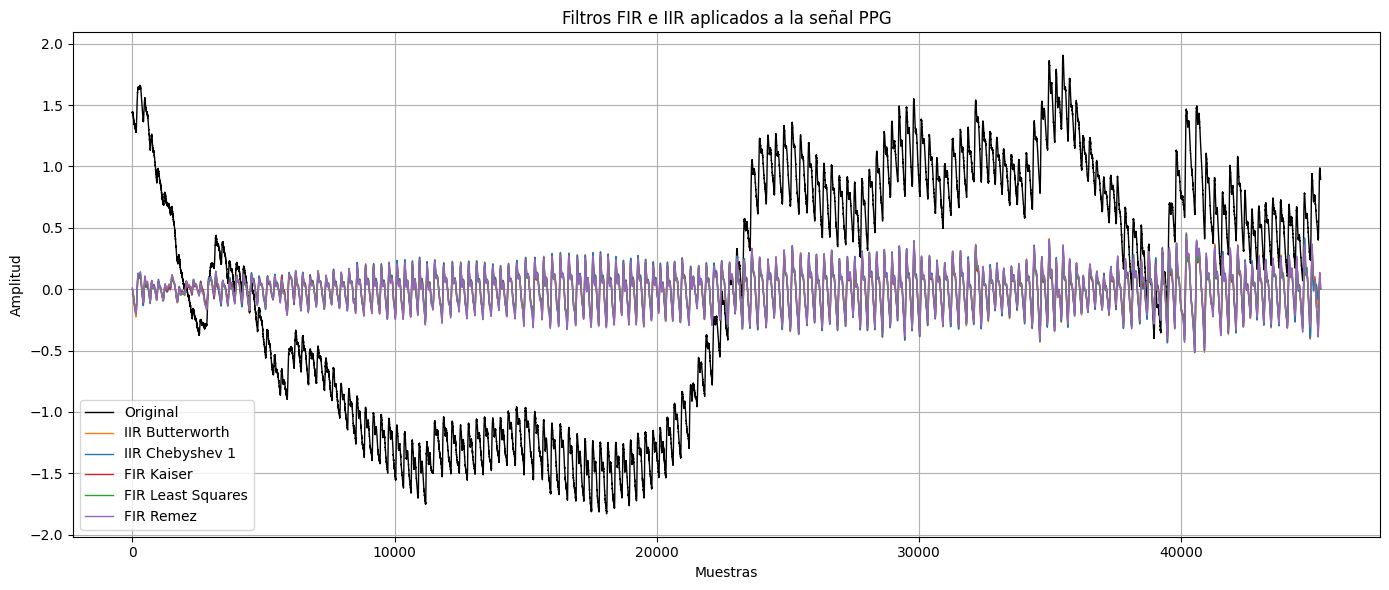

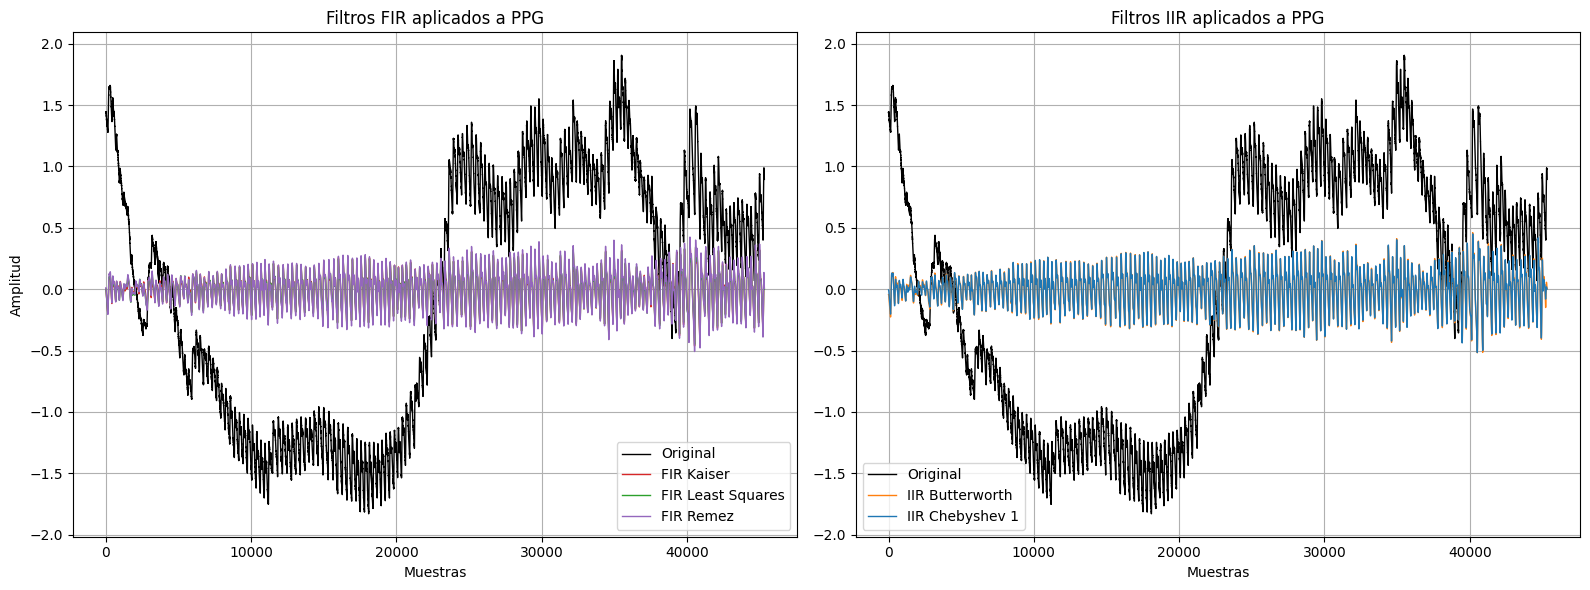

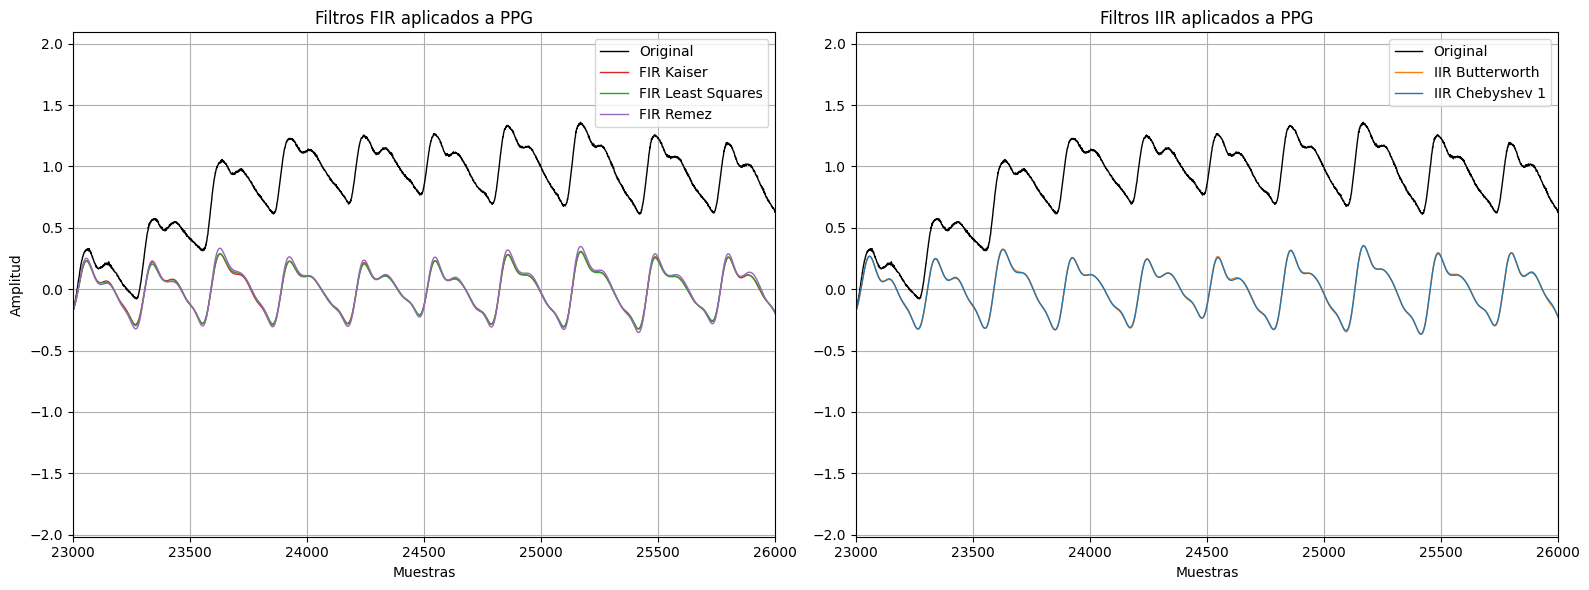

In [38]:
''' Ploteo de resultados '''
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(ppg, label='Original', color='black', linewidth=1)
ax.plot(ppg_iir_butter, label='IIR Butterworth', color='tab:orange', linewidth=1)
ax.plot(ppg_iir_cheby, label='IIR Chebyshev 1', color='tab:blue', linewidth=1)
ax.plot(ppg_fir_kaiser, label='FIR Kaiser', color='tab:red', linewidth=1)
ax.plot(ppg_fir_firls, label='FIR Least Squares', color='tab:green', linewidth=1)
ax.plot(ppg_fir_remez, label='FIR Remez', color='tab:purple', linewidth=1)

ax.set_title('Filtros FIR e IIR aplicados a la señal PPG')
ax.set_xlabel('Muestras')
ax.set_ylabel('Amplitud')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# FIR
axs[0].plot(ppg, label='Original', color='black', linewidth=1)
axs[0].plot(ppg_fir_kaiser, label='FIR Kaiser', color='tab:red', linewidth=1)
axs[0].plot(ppg_fir_firls, label='FIR Least Squares', color='tab:green', linewidth=1)
axs[0].plot(ppg_fir_remez, label='FIR Remez', color='tab:purple', linewidth=1)
axs[0].set_title('Filtros FIR aplicados a PPG')
axs[0].set_xlabel('Muestras')
axs[0].set_ylabel('Amplitud')
axs[0].legend()
axs[0].grid(True)

# IIR
axs[1].plot(ppg, label='Original', color='black', linewidth=1)
axs[1].plot(ppg_iir_butter, label='IIR Butterworth', color='tab:orange', linewidth=1)
axs[1].plot(ppg_iir_cheby, label='IIR Chebyshev 1', color='tab:blue', linewidth=1)
axs[1].set_title('Filtros IIR aplicados a PPG')
axs[1].set_xlabel('Muestras')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# FIR
axs[0].plot(ppg, label='Original', color='black', linewidth=1)
axs[0].plot(ppg_fir_kaiser, label='FIR Kaiser', color='tab:red', linewidth=1)
axs[0].plot(ppg_fir_firls, label='FIR Least Squares', color='tab:green', linewidth=1)
axs[0].plot(ppg_fir_remez, label='FIR Remez', color='tab:purple', linewidth=1)
axs[0].set_title('Filtros FIR aplicados a PPG')
axs[0].set_xlabel('Muestras')
axs[0].set_xlim(23000, 26000)  
axs[0].set_ylabel('Amplitud')
axs[0].legend()
axs[0].grid(True)

# IIR
axs[1].plot(ppg, label='Original', color='black', linewidth=1)
axs[1].plot(ppg_iir_butter, label='IIR Butterworth', color='tab:orange', linewidth=1)
axs[1].plot(ppg_iir_cheby, label='IIR Chebyshev 1', color='tab:blue', linewidth=1)
axs[1].set_title('Filtros IIR aplicados a PPG')
axs[1].set_xlabel('Muestras')
axs[1].set_xlim(23000, 26000) 
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### b) ¿Cómo definí los valores de la plantilla?

Los saqué en base a lo que hicimos en la TS5 y también buscando un poco por mi cuenta. Antes de filtrar una señal, lo lógico es ver qué bandas son las relevantes. En la TS5 había calculado los anchos de banda (95% y 98%) para las señales limpias y con ruido. Ahí se veía bien en los espectros dónde estaba el contenido útil y dónde arrancaba el ruido.

Elegí trabajar con la señal PPG porque tenía más ruido, especialmente en bajas frecuencias (movimiento de la línea de base), y eso se notaba en el espectro. Por eso puse una banda de paso de 0.5 a 5 Hz y bandas de stop a los costados (0.2 y 8 Hz).

---

### Conclusiones finales

Con los FIR tuve que meter mucha mano. Tuve que probar con distintas atenuaciones, cambiar el ripple, aflojar un poco los límites de las bandas... si uno se pone muy exigente, a veces el filtro no sale bien o necesita muchísimos coeficientes. Me llevó bastante tiempo hasta que quedó como quería.

Con los IIR fue todo más directo, mucho más rápido. Sé que los FIR tienen ventajas (como que no meten fase si usás `filtfilt`, o que son siempre estables), pero a mí los IIR me gustaron porque fueron más simples de ajustar.

Usé `filtfilt` para aplicar los filtros, así evitás el desfase. Sé que otra opción sería usar `lfilter` y después compensar la demora, pero preferí hacer todo con `filtfilt` porque es más fácil y funciona bien.
